In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,r2_score

import stan
import arviz as az

import nest_asyncio
nest_asyncio.apply()

import warnings
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")

In [13]:
#Read in data
#Do same data preprocessingas kaggle guy
#Show histplot of price
#Multiple regression stan model

## Comparison of Stan model to kaggle data analysis:

### Read in Data:

In [25]:
data = pd.read_csv("CarPrice_Assignment.csv")
data.head()

,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,...,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,1,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,2,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,3,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,4,2,audi 100 ls,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,5,2,audi 100ls,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0


### Data Preprocessing (same as kaggle analysis):

In [26]:
# Extract brand and model from CarName
data['brand'] = data['CarName'].apply(lambda x: x.split(' ')[0])
data['model'] = data['CarName'].apply(lambda x: ' '.join(x.split(' ')[1:]))

# Define categorical and numerical columns
categorical_columns = ['fueltype', 'aspiration', 'doornumber', 'carbody', 'drivewheel',
                       'enginelocation', 'enginetype', 'cylindernumber', 'fuelsystem', 'brand', 'model']
numerical_columns = ['wheelbase', 'carlength', 'carwidth', 'carheight', 'curbweight',
                     'enginesize', 'boreratio', 'stroke', 'compressionratio', 'horsepower',
                     'peakrpm', 'citympg', 'highwaympg']

# Encoding categorical variables
label_encoder = LabelEncoder()
for column in categorical_columns:
    data[column] = label_encoder.fit_transform(data[column])

# Feature engineering
data['power_to_weight_ratio'] = data['horsepower'] / data['curbweight']
for column in numerical_columns:
    data[f'{column}_squared'] = data[column] ** 2
data['log_enginesize'] = np.log(data['enginesize'] + 1)

# Feature scaling
scaler = StandardScaler()
data[numerical_columns] = scaler.fit_transform(data[numerical_columns])

data.head()

,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,...,curbweight_squared,enginesize_squared,boreratio_squared,stroke_squared,compressionratio_squared,horsepower_squared,peakrpm_squared,citympg_squared,highwaympg_squared,log_enginesize
0,1,3,alfa-romero giulia,1,0,1,0,2,0,-1.690772,...,6492304,16900,12.0409,7.1824,81.0,12321,25000000,441,729,4.875197
1,2,3,alfa-romero stelvio,1,0,1,0,2,0,-1.690772,...,6492304,16900,12.0409,7.1824,81.0,12321,25000000,441,729,4.875197
2,3,1,alfa-romero Quadrifoglio,1,0,1,2,2,0,-0.708596,...,7969329,23104,7.1824,12.0409,81.0,23716,25000000,361,676,5.030438
3,4,2,audi 100 ls,1,0,0,3,1,0,0.173698,...,5461569,11881,10.1761,11.5600,100.0,10404,30250000,576,900,4.700480
4,5,2,audi 100ls,1,0,0,3,0,0,0.107110,...,7974976,18496,10.1761,11.5600,64.0,13225,30250000,324,484,4.919981


<Axes: xlabel='price', ylabel='Count'>

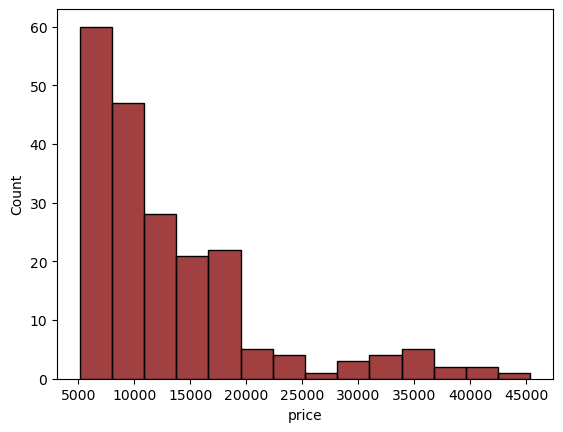

In [27]:
# Inspect the price data
sns.histplot(data.price, color='maroon')

<Axes: xlabel='price', ylabel='Count'>

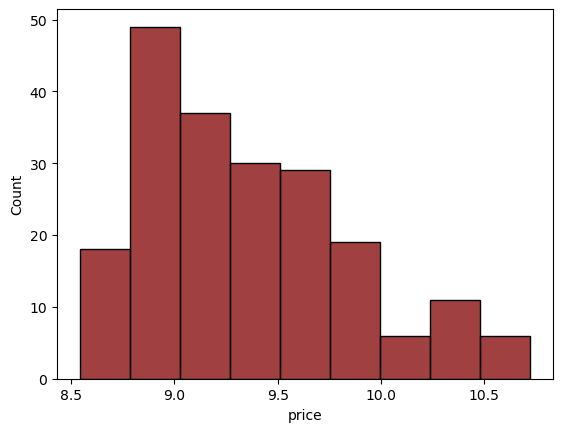

In [30]:
# Price data is not normally distribited, so do log transform
log_price = np.log(data.price)
sns.histplot(log_price, color='maroon')

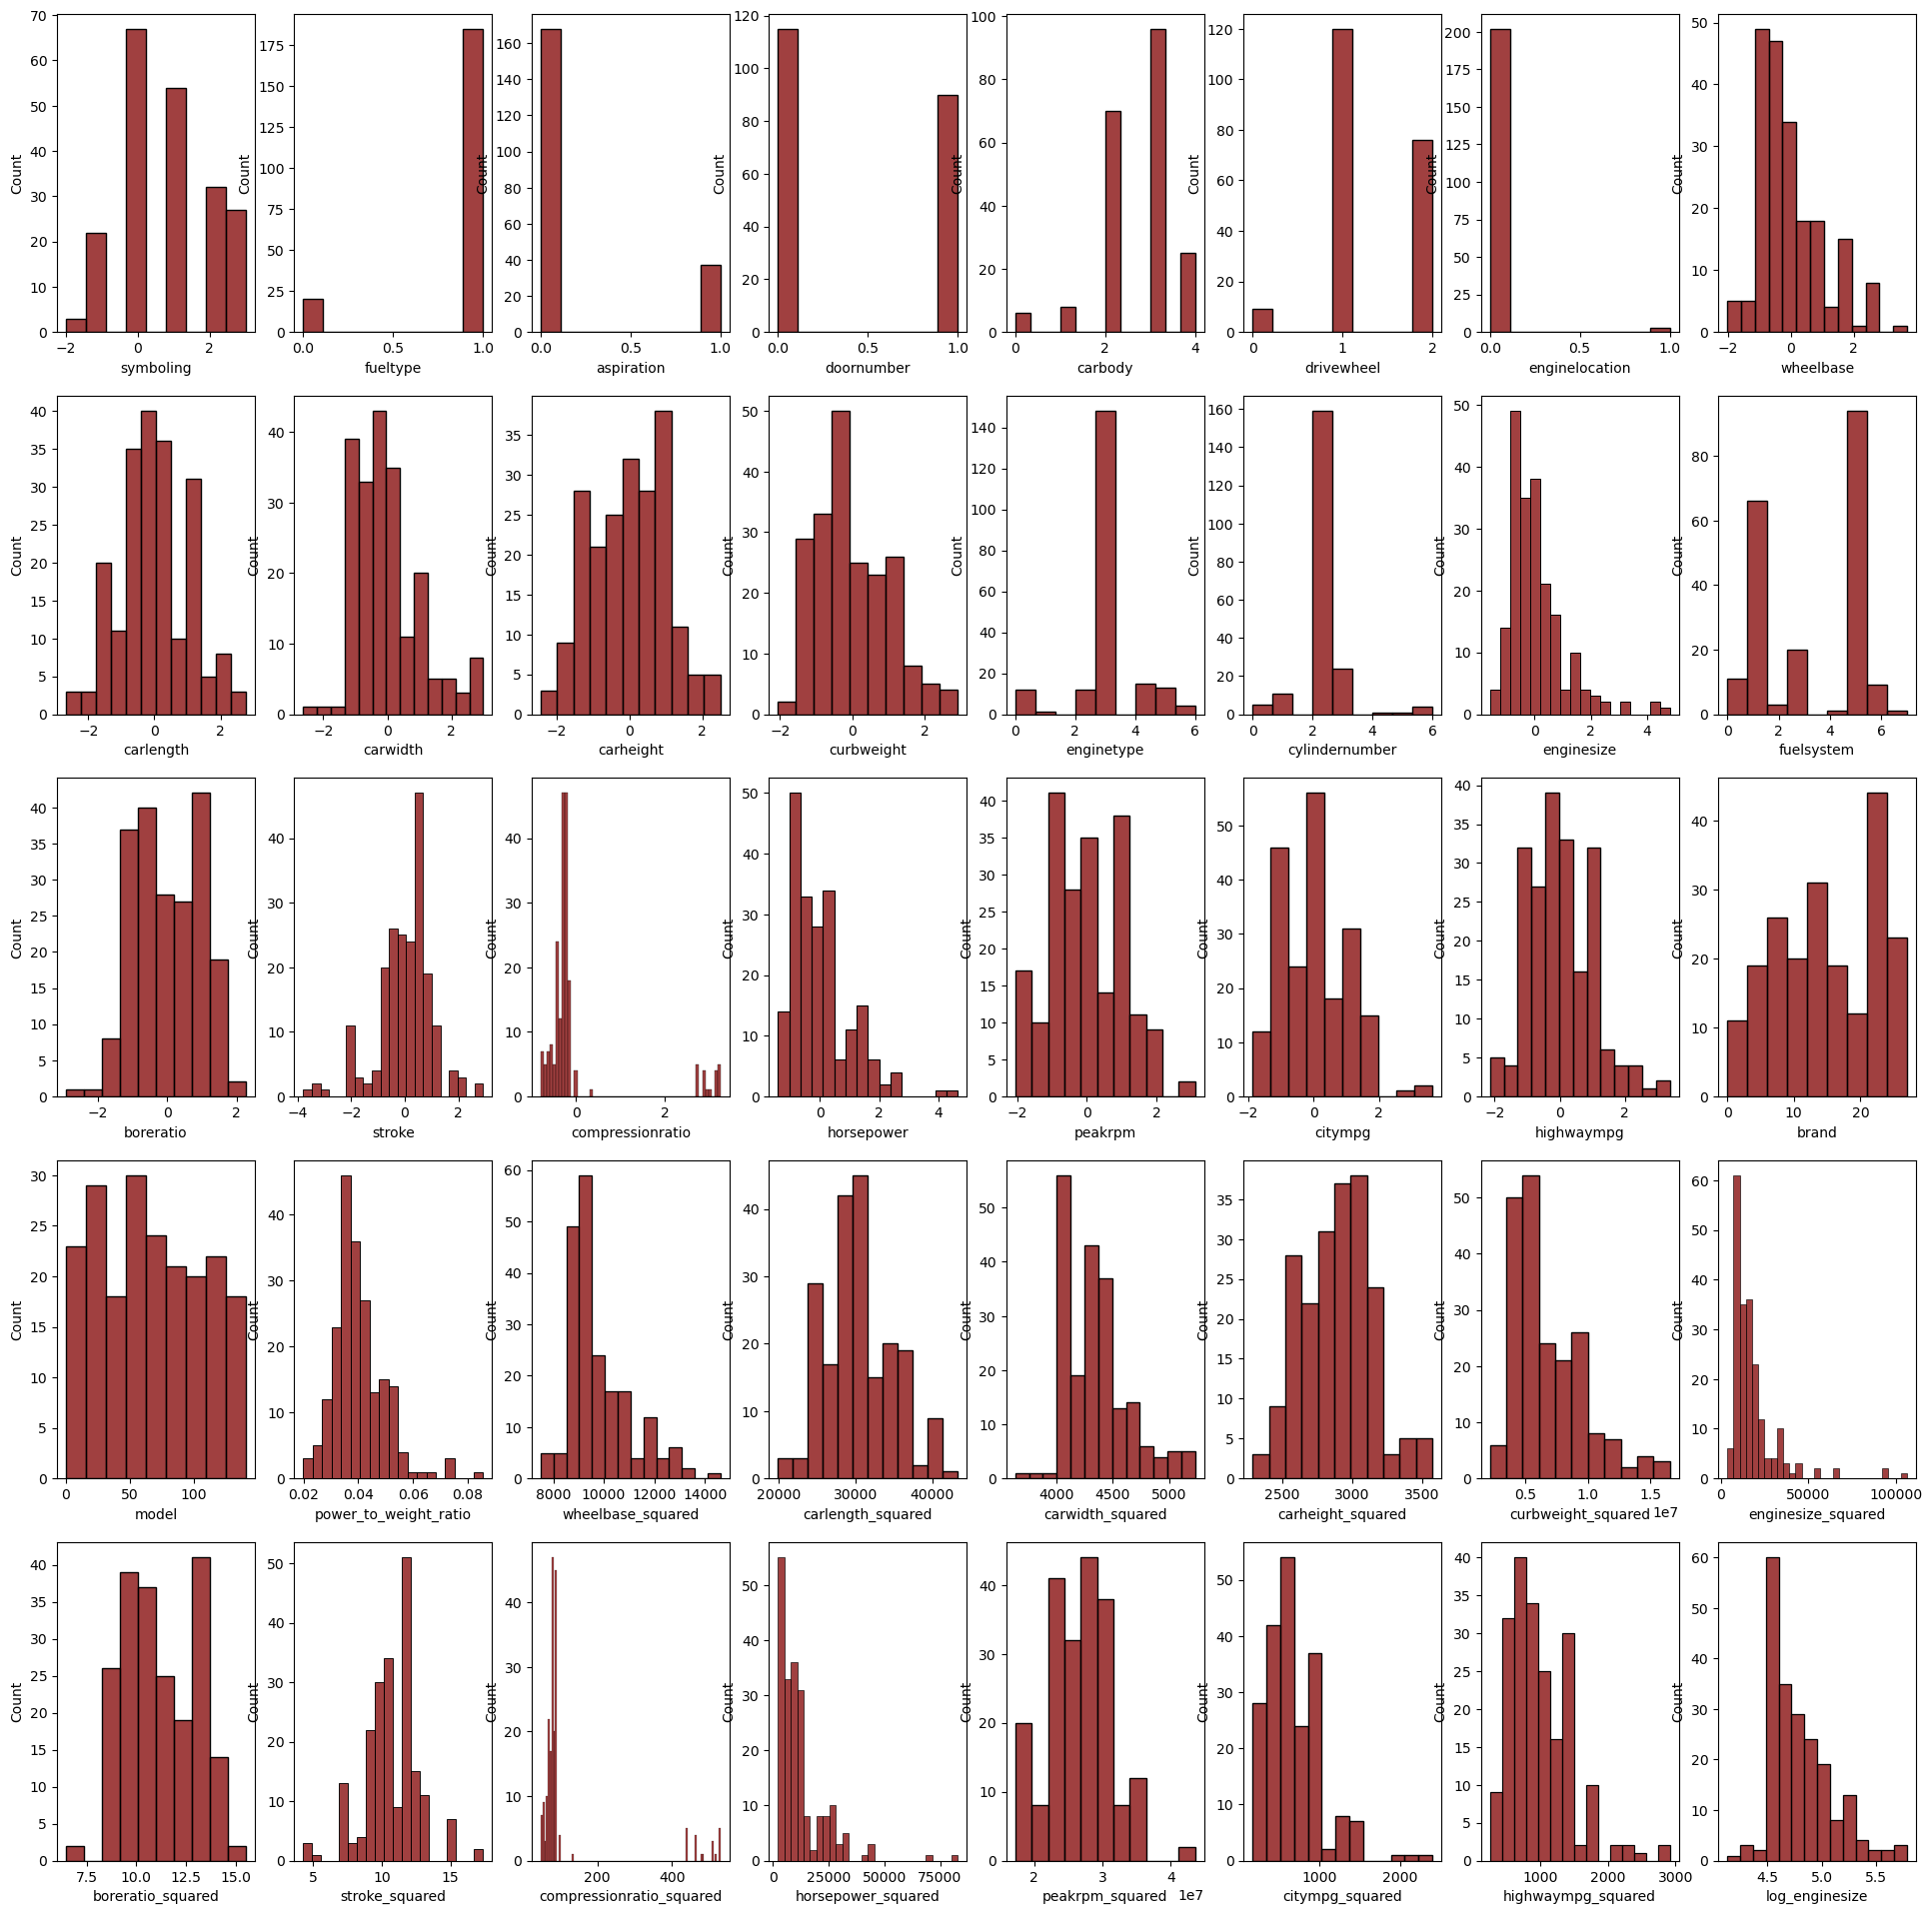

In [220]:
# Inspect histplots of all features
_, ax = plt.subplots(5, 8, figsize=(24, 24))
ax = ax.flatten()
cols = np.array(data.columns)
cols = cols[cols != 'car_ID']
cols = cols[cols != 'CarName']
cols = cols[cols != 'price']
for col, a in zip(cols, ax):
    sns.histplot(data[col], ax=a, color='maroon')

In [242]:
# Use all possible features (don't use squared features that kaggle analysis uses, this makes model not converge)
use_data = data.iloc[:, :29].drop(['car_ID', 'CarName', 'price'], axis=1)
use_data.columns

Index(['symboling', 'fueltype', 'aspiration', 'doornumber', 'carbody',
       'drivewheel', 'enginelocation', 'wheelbase', 'carlength', 'carwidth',
       'carheight', 'curbweight', 'enginetype', 'cylindernumber', 'enginesize',
       'fuelsystem', 'boreratio', 'stroke', 'compressionratio', 'horsepower',
       'peakrpm', 'citympg', 'highwaympg', 'brand', 'model',
       'power_to_weight_ratio'],
      dtype='object')

In [254]:
# Use all possible features (don't use squared features that kaggle analysis uses, this makes model not converge)
use_data = data.iloc[:, list(range(29)) + [-1]].drop(['car_ID', 'CarName', 'price'], axis=1)
use_data.columns

Index(['symboling', 'fueltype', 'aspiration', 'doornumber', 'carbody',
       'drivewheel', 'enginelocation', 'wheelbase', 'carlength', 'carwidth',
       'carheight', 'curbweight', 'enginetype', 'cylindernumber', 'enginesize',
       'fuelsystem', 'boreratio', 'stroke', 'compressionratio', 'horsepower',
       'peakrpm', 'citympg', 'highwaympg', 'brand', 'model',
       'power_to_weight_ratio', 'log_enginesize'],
      dtype='object')

In [255]:
# Split data into train and test set
X = np.array(use_data)
y = np.array(log_price)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Linear Regression Stan Model:

In [195]:
program_code = """
data {
    int<lower=1> N;
    int<lower=0> K;
    matrix[N, K] X;
    vector[N] y;
    int<lower=1> N_test;
    matrix[N_test, K] X_test;
}

parameters {
    real<lower=0> sigma;
    real alpha;
    vector[K] beta;
}

model {
    // Priors
    sigma ~ normal(0, 10);
    alpha ~ normal(9.2, 2);
    beta ~ normal(9.2, 2);

    // Likelihood
    y ~ normal(alpha + X * beta, sigma);
}

generated quantities {
    array[N] real gen_y;
    gen_y = normal_rng(alpha + X * beta, sigma);

    array[N_test] real pred_y;
    pred_y = normal_rng(alpha + X_test * beta, sigma);
}
"""

In [256]:
# Prepare data in Stan friendly format
data_dict = {
    'N': X_train.shape[0],
    'K': X_train.shape[1],
    'X': X_train,
    'y': y_train,
    'N_test': X_test.shape[0],
    'X_test': X_test
}

# Compile model
regression_model = stan.build(program_code, data=data_dict)

# Sample 4 x 2000 random draws from the posterior
regression_fit = regression_model.sample(num_chains=4, num_warmup=1000, num_samples=2000)

Building...



Building: found in cache, done.Sampling:   0%
Sampling:   0% (1/12000)
Sampling:   0% (2/12000)
Sampling:   0% (3/12000)
Sampling:   0% (4/12000)
Sampling:   1% (103/12000)
Sampling:   2% (202/12000)
Sampling:   3% (301/12000)
Sampling:   3% (400/12000)
Sampling:   4% (500/12000)
Sampling:   5% (600/12000)
Sampling:   6% (700/12000)
Sampling:   7% (800/12000)
Sampling:   8% (900/12000)
Sampling:   8% (1000/12000)
Sampling:   9% (1100/12000)
Sampling:  10% (1200/12000)
Sampling:  11% (1300/12000)
Sampling:  12% (1400/12000)
Sampling:  12% (1500/12000)
Sampling:  13% (1600/12000)
Sampling:  14% (1700/12000)
Sampling:  15% (1800/12000)
Sampling:  16% (1900/12000)
Sampling:  17% (2000/12000)
Sampling:  18% (2100/12000)
Sampling:  18% (2200/12000)
Sampling:  19% (2300/12000)
Sampling:  20% (2400/12000)
Sampling:  21% (2500/12000)
Sampling:  22% (2600/12000)
Sampling:  22% (2700/12000)
Sampling:  23% (2800/12000)
Sampling:  24% (2900/12000)
Sampling:  25% (3000/12000)
Sampling:  26% (3100/1

In [246]:
regression_results = regression_fit.to_frame()
regression_results.head()

parameters,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,sigma,alpha,beta.1,...,pred_y.32,pred_y.33,pred_y.34,pred_y.35,pred_y.36,pred_y.37,pred_y.38,pred_y.39,pred_y.40,pred_y.41
draws,,,,,,,,,,,,,,,,,,,,,
0,-40.315821,0.999837,0.019041,7.0,255.0,0.0,56.725381,0.157303,8.067291,0.021924,...,8.841182,8.833793,9.829932,9.201897,10.210951,9.181755,9.416041,8.802707,9.562133,9.075952
1,-37.300942,0.882274,0.018208,8.0,255.0,0.0,58.288582,0.147105,7.883579,0.017602,...,8.859192,8.760799,10.022201,9.001083,10.274118,9.241043,9.418547,8.940827,9.453113,8.933757
2,-39.094054,0.900026,0.021600,8.0,255.0,0.0,50.538278,0.151826,7.818868,-0.008540,...,8.969103,8.676439,9.986711,9.150518,10.455339,9.224974,9.566486,8.848922,9.445962,9.021303
3,-30.766719,0.999837,0.019014,8.0,255.0,0.0,40.866110,0.154795,7.864839,0.009564,...,9.028505,8.536259,10.040733,9.368690,10.454063,9.215038,9.106332,8.770122,9.580026,8.603789
4,-38.889773,0.977884,0.019041,8.0,255.0,0.0,54.366766,0.145829,8.102966,-0.015757,...,8.932332,8.764600,9.761414,9.019205,10.181781,9.173870,9.225243,8.868840,9.639117,8.709285


In [257]:
regression_summary = az.summary(regression_fit)
regression_summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma,0.154,0.009,0.137,0.173,0.000,0.000,7527.0,6164.0,1.0
alpha,8.154,1.238,5.787,10.446,0.020,0.014,3734.0,4698.0,1.0
beta[0],-0.002,0.017,-0.035,0.030,0.000,0.000,6058.0,5896.0,1.0
beta[1],1.293,0.401,0.550,2.059,0.006,0.004,4247.0,5240.0,1.0
beta[2],0.083,0.055,-0.022,0.184,0.001,0.001,5778.0,5740.0,1.0
...,...,...,...,...,...,...,...,...,...
pred_y[36],9.263,0.169,8.934,9.568,0.002,0.001,8264.0,7888.0,1.0
pred_y[37],9.327,0.176,8.989,9.651,0.002,0.001,8146.0,7547.0,1.0
pred_y[38],8.745,0.165,8.433,9.051,0.002,0.001,8077.0,7959.0,1.0
pred_y[39],9.513,0.164,9.218,9.828,0.002,0.001,8246.0,8056.0,1.0


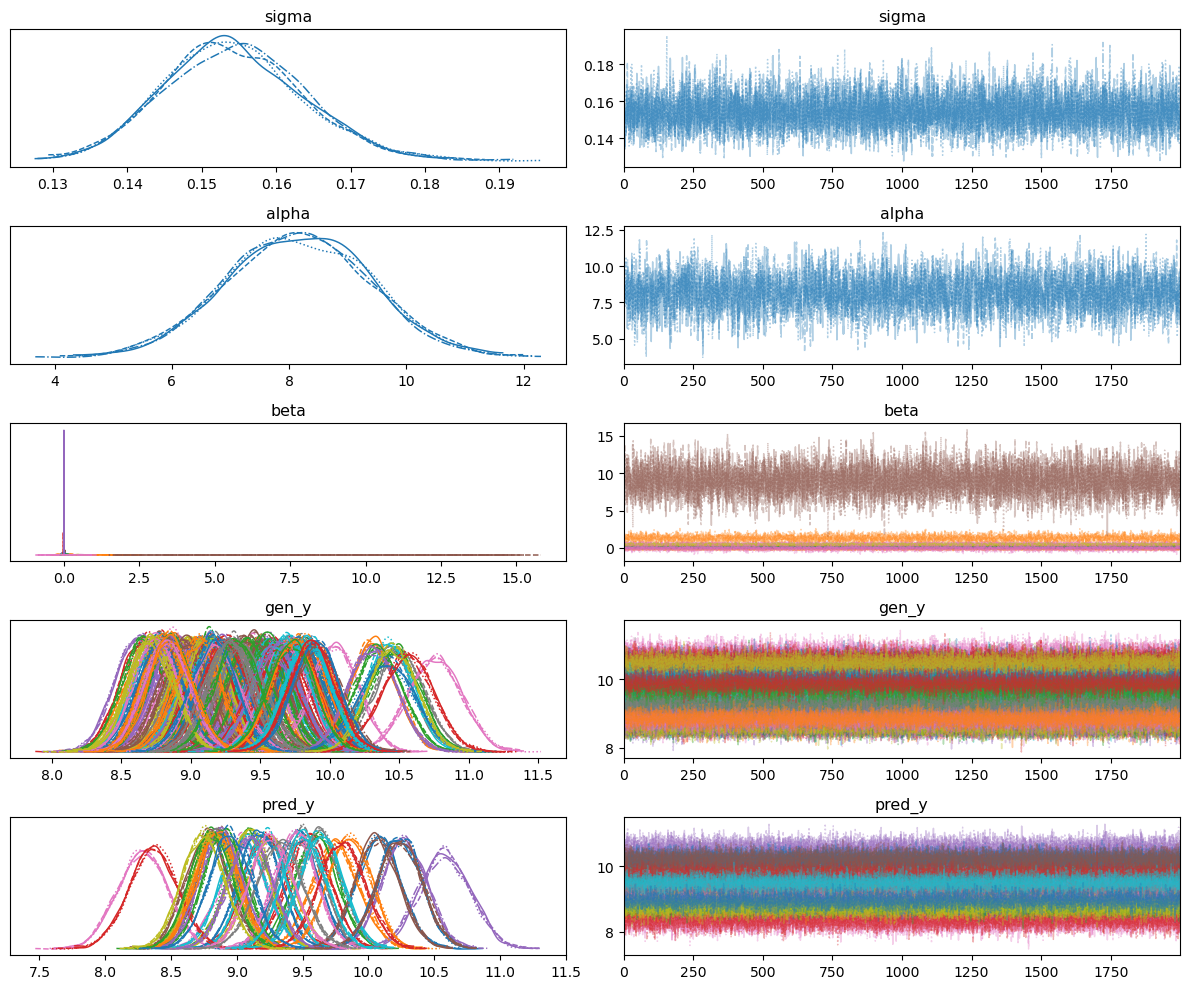

In [258]:
_ = az.plot_trace(regression_fit)
plt.tight_layout()

In [259]:
# Generative Performance
preds = regression_fit.__getitem__('gen_y')
preds_mean = preds.mean(axis=1)
rmse = np.sqrt(np.mean((preds_mean - y_train)**2))
r2 = r2_score(y_train, preds_mean)
print("RMSE:", rmse)
print("R2-Score:", r2)

RMSE: 0.13994975425278797
R2-Score: 0.9209909383858469


In [260]:
# Predictive Performance
preds = regression_fit.__getitem__('pred_y')
preds_mean = preds.mean(axis=1)
rmse = np.sqrt(np.mean((preds_mean - y_test)**2))
r2 = r2_score(y_test, preds_mean)
print("RMSE:", rmse)
print("R2-Score:", r2)

RMSE: 0.18417834598200614
R2-Score: 0.874977940226744
